# Let's first provide an implementation of a standard neural network

In [1]:
install.packages("tseriesChaos")
require(tseriesChaos)

f <- function(net) { return (1 / (1 + exp(-net))) }

df_dnet <- function(f_net) { return (f_net * (1 - f_net)) }

mlp.architecture <- function(input.length = 2, 
			     hidden.length = 2, 
			     output.length = 1,
			     activation.function = f,
			     derivate.activation.function = df_dnet) {
	model = list()
	model$input.length = input.length
	model$hidden.length = hidden.length
	model$output.length = output.length

	model$hidden = matrix(runif(min=-0.5, max=0.5, 
				    n=hidden.length*(input.length+1)),
			      		nrow=hidden.length, ncol=input.length+1)

	model$output = matrix(runif(min=-0.5, max=0.5, 
				    n=output.length*(hidden.length+1)),
			      		nrow=output.length, ncol=hidden.length+1)

	model$f = activation.function
	model$df_dnet = derivate.activation.function

	return (model)
}

mlp.forward <- function(model, Xp) {

	# Xp = c(0, 0)
	# $hidden
	#		w1	   w2	     theta
	#		  [,1]      [,2]       [,3]
	#neuron	[1,] 0.2255831 0.0518211 -0.1055830
	#neuron	[2,] 0.2261619 0.1775540 -0.3730913

	# Hidden layer
	net_h_p = model$hidden %*% c(Xp, 1)
	f_net_h_p = model$f(net_h_p)

	# Output layer
	net_o_p = model$output %*% c(as.vector(ts(f_net_h_p)), 1)
	f_net_o_p = model$f(net_o_p)

	# results
	ret = list()

	ret$net_h_p = net_h_p
	ret$net_o_p = net_o_p

	ret$f_net_h_p = f_net_h_p
	ret$f_net_o_p = f_net_o_p

	return (ret)
}

mlp.backpropagation <- function(model, dataset, eta=0.5, 
				threshold=1e-3, maxIters=1000, debug=T) {

	squaredError = 2*threshold
	counter = 0

	while (squaredError > threshold && counter < maxIters) {
		squaredError = 0

		for (p in 1:nrow(dataset)) {
			Xp = as.vector(ts(dataset[p, 1:model$input.length]))
			Yp = as.vector(ts(dataset[p, (model$input.length+1):ncol(dataset)]))

			results = mlp.forward(model, Xp)

			Op = results$f_net_o_p
			error = Yp - Op

			squaredError = squaredError + sum(error^2)

			# Training
			# Output
			#	
			# 	delta_o = (Yp - Op) * f_o_p'(net_o_p)
			#	w(t+1) = w(t) - eta * dE_dw
			#	w(t+1) = w(t) - eta * delta_o * i_pj

			delta_o_p = error * model$df_dnet(results$f_net_o_p)

			# Hidden
			#
			#	delta_h = f_h_p'(net_h_p) * sum(delta_o * w_o_kj)
			#	w(t+1) = w(t) - eta * delta_h * Xp
			#
			w_o_kj = model$output[,1:model$hidden.length]

			delta_h_p = as.numeric(model$df_dnet(results$f_net_h_p)) * 
					(as.numeric(delta_o_p) %*% w_o_kj)

			# Finally Training
			model$output = model$output + 
				eta * (delta_o_p %*% as.vector(c(results$f_net_h_p,1)))
			model$hidden = model$hidden + 
				eta * (t(delta_h_p) %*% as.vector(c(Xp,1)))
		}

		squaredError = squaredError / nrow(dataset)

		if (debug) {
			if (counter %% 100 == 0) {
				cat("Average squared error = ", squaredError, "\n")
			}
		}

		counter = counter + 1
	}

	return (model)
}


The downloaded binary packages are in
	/var/folders/3v/tq04l85n0zx5v9bvqfvh5q2r0000gn/T//RtmpasnR00/downloaded_packages


Loading required package: tseriesChaos


# Let's also define a logistic function to generate random data

In [2]:
require(tseriesChaos)

logistic <- function(r=3.8, iter=1000, x=0.5) {

	series = c()
	for (i in 1:iter) {
		series = c(series, x)
		x = r*x*(1-x)
	}

	return (series)
}


# Takens 1981
#
# m -> eixos do espaço
# d -> time delay ou atraso temporal
#
# X = {x1, x2, x3, x4, x5, ..., xn}
#
# e1 = (xi, xi+d, xi+2*d, ..., xi+(m-1)*d)
#
# Mapa Logístico
# ==============
#
# m = 2		---> Kennel (False Nearest Neighbors)
# d = 1		---> Fraser and Swinney (Auto-Mutual Information)
#
# e1 = (x1, x2)
# e2 = (x2, x3)
# e3 = (x3, x4)
# ...
# en-1 = (xn-1,xn)
#
logistic.accuracy <- function(series, m=2, d=1, eta=0.1,
				n.hyperplanes = 5, train.size=0.75, 
					threshold=1e-3) {

	dataset = as.data.frame(embedd(series, m=m, d=d))

	train.length = floor(train.size * nrow(dataset))
	ids = sample(1:nrow(dataset), size=train.length)
	train = dataset[ids,]
	test = dataset[-ids,]

	model = mlp.architecture(1, n.hyperplanes, 1)
	trained = mlp.backpropagation(model, train, eta=eta, threshold=threshold)

	mat = NULL
	for (p in 1:nrow(test)) {
		Xp = as.numeric(test[p,1])
		Yp = as.numeric(test[p,2])
		Op = as.numeric(mlp.forward(trained, Xp)$f_net_o_p)

		mat = rbind(mat, cbind(Yp, Op))
	}

	return (mat)
}

# Now let's create a data series

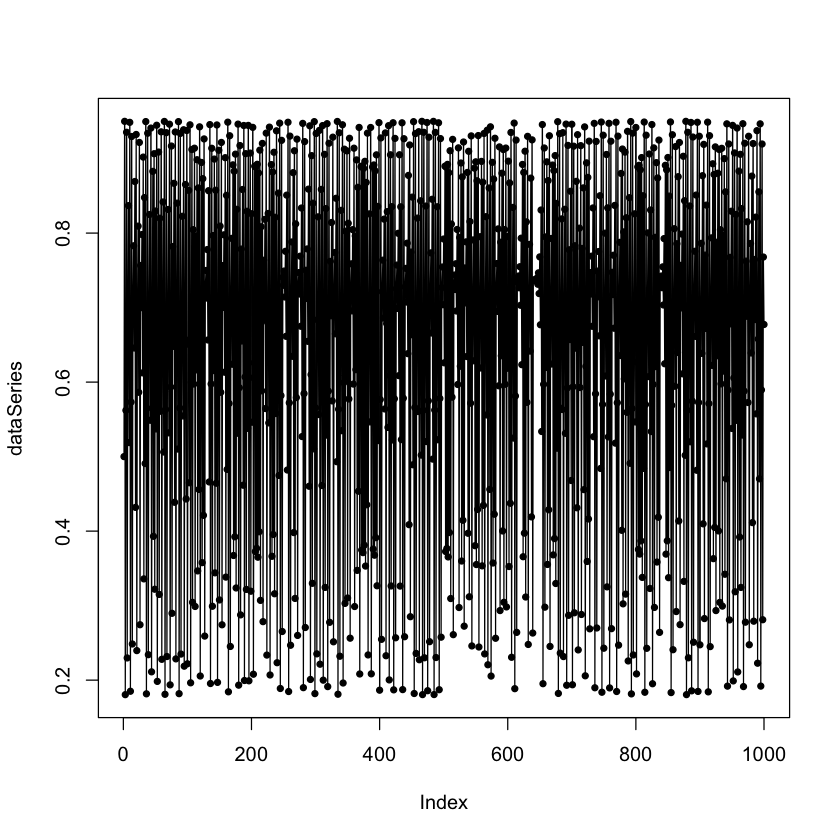

In [3]:
dataSeries = logistic()

plot(dataSeries, pch=20, type="o")

# Let's look a little closer

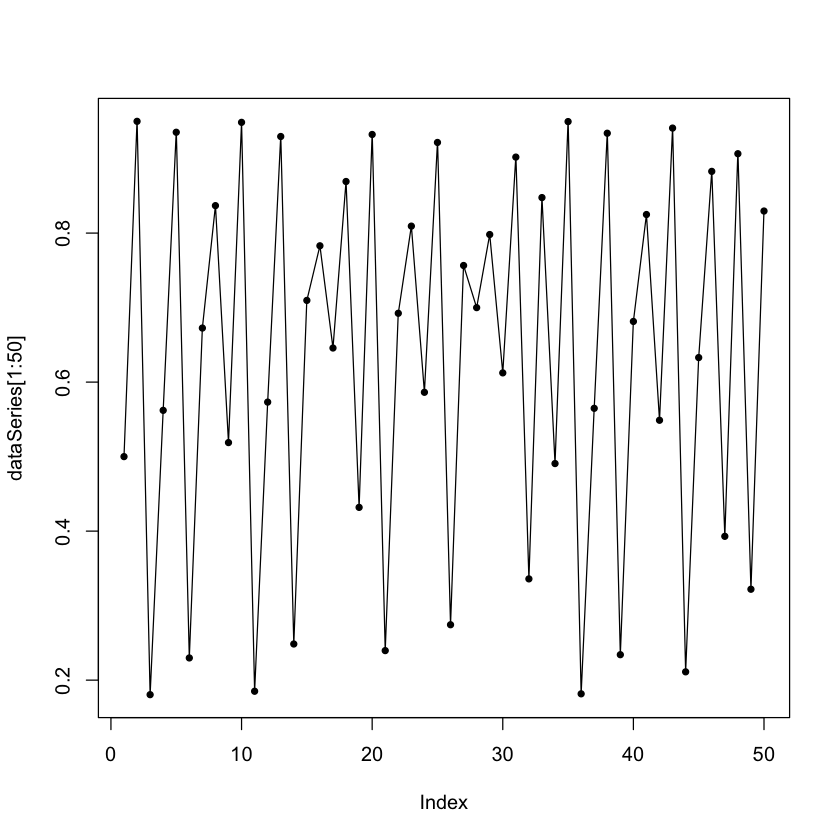

In [4]:
plot(dataSeries[1:50], pch=20, type="o")

# Now let's train our neural network

In [5]:
regression = logistic.accuracy(dataSeries)

Average squared error =  0.06123014 
Average squared error =  0.01727133 
Average squared error =  0.009552472 
Average squared error =  0.001375956 


# Let's split the train and predicted values and plot them

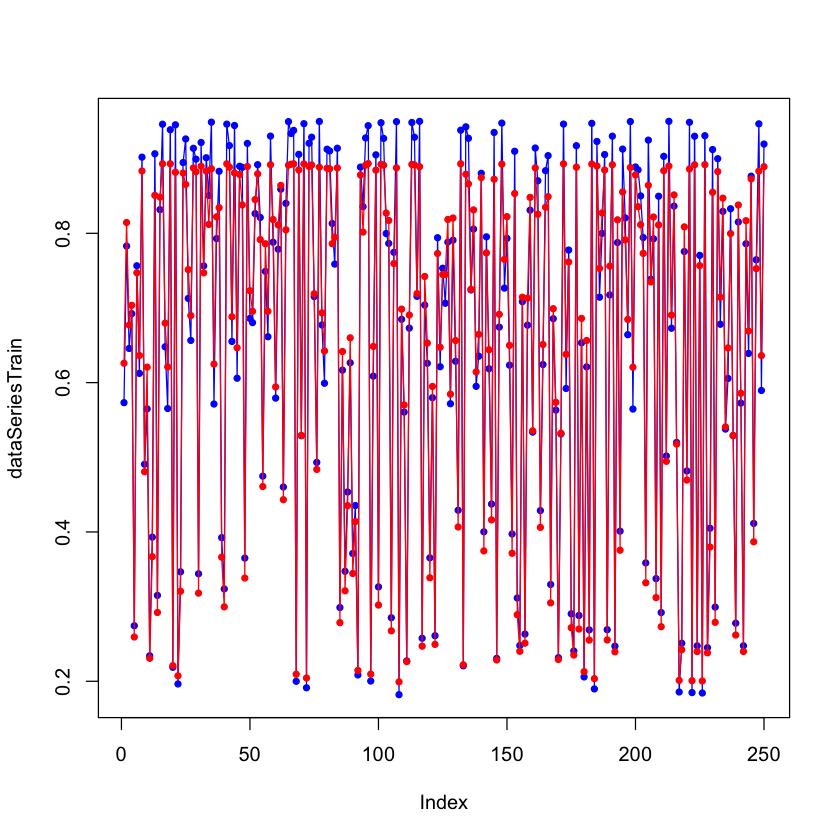

In [6]:
dataSeriesTrain = regression[,1]
dataSeriesPrediction = regression[,2]

plot(dataSeriesTrain, pch=20, type="o", col="blue")
lines(dataSeriesPrediction, pch=20, type="o", col="red")

# Again, taking a closer look

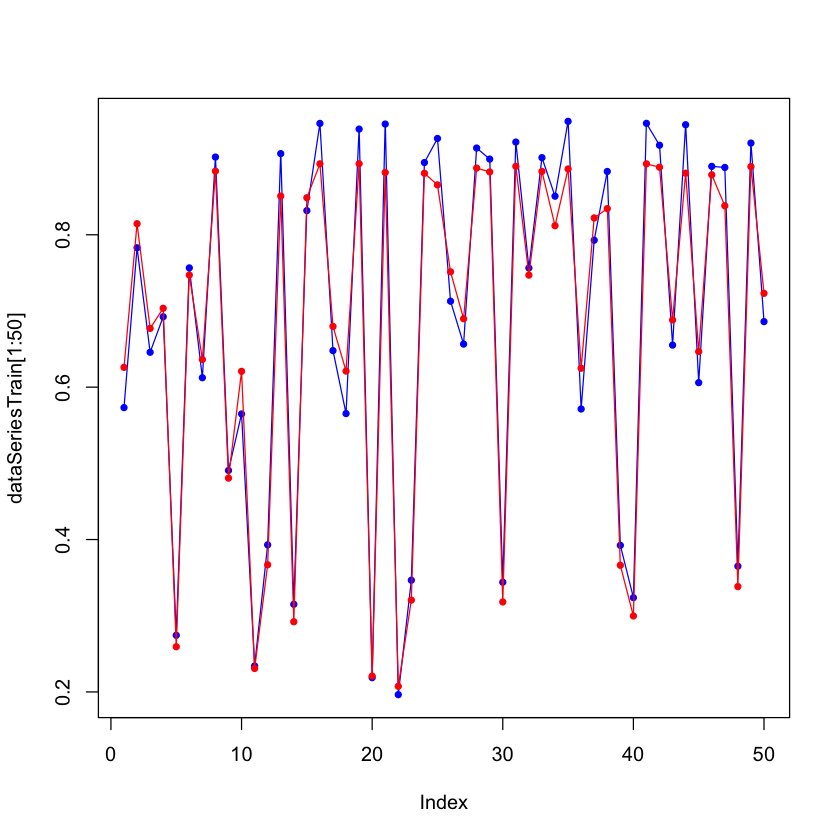

In [7]:
plot(dataSeriesTrain[1:50], pch=20, type="o", col="blue")
lines(dataSeriesPrediction[1:50], pch=20, type="o", col="red")

# What if we train we smaller dataset?

Average squared error =  0.07256664 
Average squared error =  0.01667091 
Average squared error =  0.01072363 
Average squared error =  0.007914419 
Average squared error =  0.002594754 


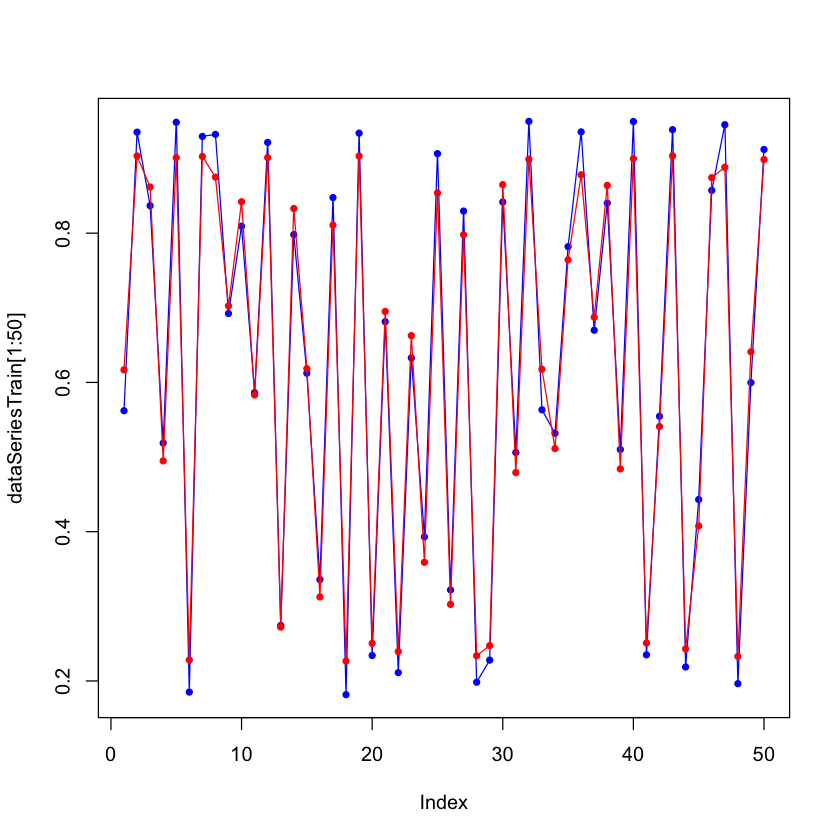

In [8]:
regression = logistic.accuracy(dataSeries, train.size = 0.5)
dataSeriesTrain = regression[,1]
dataSeriesPrediction = regression[,2]
plot(dataSeriesTrain[1:50], pch=20, type="o", col="blue")
lines(dataSeriesPrediction[1:50], pch=20, type="o", col="red")

# Let's try add more neurons ...

Average squared error =  0.06112504 
Average squared error =  0.02079411 
Average squared error =  0.02054347 
Average squared error =  0.02023699 
Average squared error =  0.01947116 
Average squared error =  0.0117812 


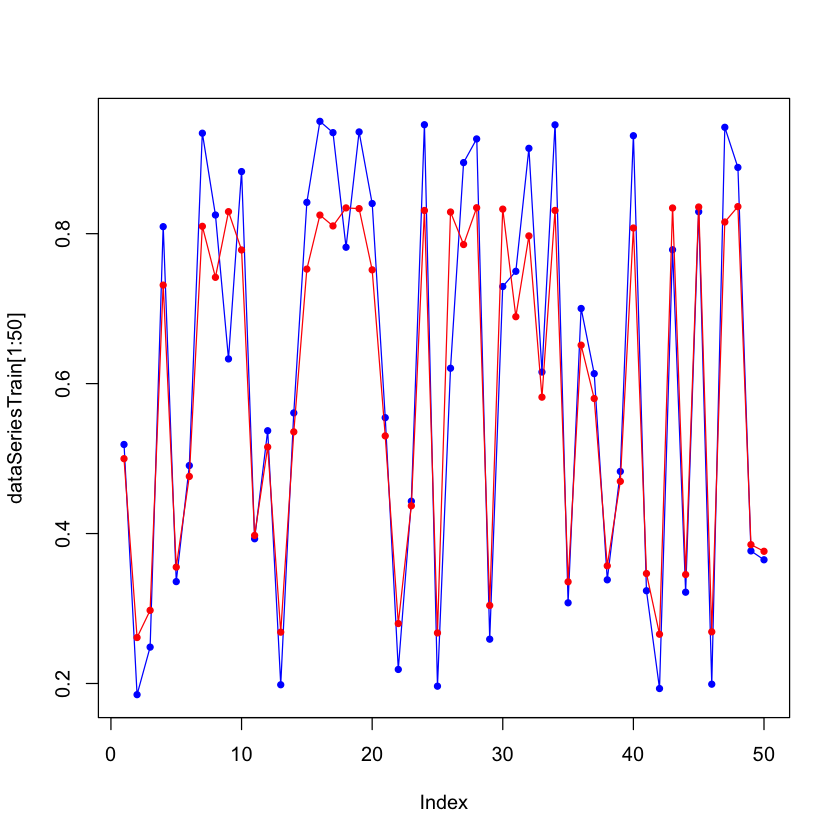

In [9]:
regression = logistic.accuracy(dataSeries, threshold = 0.01, n.hyperplanes = 25)
dataSeriesTrain = regression[,1]
dataSeriesPrediction = regression[,2]
plot(dataSeriesTrain[1:50], pch=20, type="o", col="blue")
lines(dataSeriesPrediction[1:50], pch=20, type="o", col="red")